In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
os.chdir('/Users/prajwal/Developer/assessment')

In [3]:
# Load datasets
customers = pd.read_csv("Zeotap/Data/Customers.csv")
products = pd.read_csv("Zeotap/Data/Products.csv")
transactions = pd.read_csv("Zeotap/Data/Transactions.csv")

In [4]:
# Display's the information of the datasets
customers.info()
products.info()
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  


In [5]:
# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [6]:
# Determine analysis date (latest transaction date)
analysis_date = transactions['TransactionDate'].max()

# Process Customers: compute Tenure
customers['Tenure'] = (analysis_date - customers['SignupDate']).dt.days

# One-hot encode Region
customers_encoded = pd.get_dummies(customers, columns=['Region'], prefix='Region')

# Merge Transactions with Products to get Category
transactions = pd.merge(transactions, products[['ProductID', 'Category']], on='ProductID', how='left')

In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price            1000 non-null   float64       
 7   Category         1000 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 62.6+ KB


In [8]:
# Aggregate transaction data per CustomerID
agg_transactions = transactions.groupby('CustomerID').agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalQuantity=('Quantity', 'sum'),
    TotalSpent=('TotalValue', 'sum'),
    UniqueCategories=('Category', 'nunique'),
    last_purchase_date=('TransactionDate', 'max')
).reset_index()

agg_transactions['Recency'] = (analysis_date - agg_transactions['last_purchase_date']).dt.days
agg_transactions['AvgTransactionValue'] = agg_transactions['TotalSpent'] / agg_transactions['TotalTransactions']

In [9]:
agg_transactions.head()

,CustomerID,TotalTransactions,TotalQuantity,TotalSpent,UniqueCategories,last_purchase_date,Recency,AvgTransactionValue
0,C0001,5,12,3354.52,3,2024-11-02 17:04:16,55,670.904
1,C0002,4,10,1862.74,2,2024-12-03 01:41:41,25,465.685
2,C0003,4,14,2725.38,3,2024-08-24 18:54:04,125,681.345
3,C0004,8,23,5354.88,3,2024-12-23 14:13:52,4,669.360
4,C0005,3,7,2034.24,2,2024-11-04 00:30:22,54,678.080


In [10]:
# Compute Frequency
def calculate_frequency(group):
    if len(group) < 2:
        return 0
    else:
        sorted_dates = group.sort_values('TransactionDate')['TransactionDate']
        deltas = sorted_dates.diff().dt.days.dropna()
        return deltas.mean()

frequency = transactions.groupby('CustomerID').apply(calculate_frequency).reset_index(name='Frequency')

In [11]:
frequency.head()

,CustomerID,Frequency
0,C0001,71.750000
1,C0002,92.333333
2,C0003,62.333333
3,C0004,42.142857
4,C0005,116.500000


In [12]:
# Merge frequency into agg_transactions
agg_transactions = pd.merge(agg_transactions, frequency, on='CustomerID', how='left')

# Merge with customers_encoded
merged_df = pd.merge(customers_encoded, agg_transactions, on='CustomerID', how='left')

# Fill NaN values for customers with no transactions
merged_df['TotalTransactions'] = merged_df['TotalTransactions'].fillna(0)
merged_df['TotalQuantity'] = merged_df['TotalQuantity'].fillna(0)
merged_df['TotalSpent'] = merged_df['TotalSpent'].fillna(0)
merged_df['UniqueCategories'] = merged_df['UniqueCategories'].fillna(0)
merged_df['Recency'] = merged_df['Recency'].fillna(9999)  # 9999 indicates no purchases
merged_df['AvgTransactionValue'] = merged_df['AvgTransactionValue'].fillna(0)
merged_df['Frequency'] = merged_df['Frequency'].fillna(0)

In [13]:
# Drop unnecessary columns
merged_df.drop(columns=['CustomerID', 'CustomerName', 'SignupDate', 'last_purchase_date'], inplace=True)

In [14]:
# Prepare features for clustering
X = merged_df.copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [15]:
# Determine optimal number of clusters using DB Index
db_scores = []
silhouette_scores = []
calinski_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))

/Users/prajwal/Developer/assessment/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prajwal/Developer/assessment/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prajwal/Developer/assessment/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prajwal/Developer/assessment/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1

In [16]:
# Find the optimal number of clusters with the lowest DB Index
optimal_clusters = cluster_range[np.argmin(db_scores)]

In [17]:
# Add cluster labels to the dataframe
merged_df['Cluster'] = labels

In [18]:
# Train final model with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(X_scaled)

/Users/prajwal/Developer/assessment/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [19]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

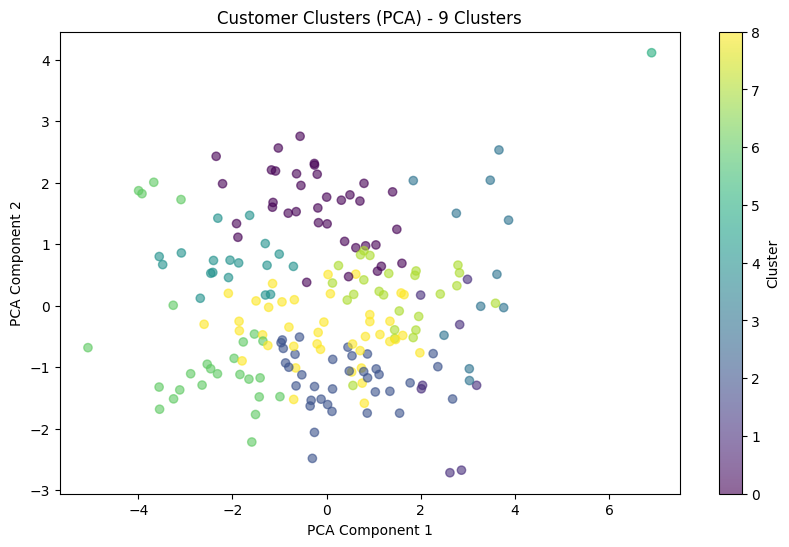

In [20]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title(f'Customer Clusters (PCA) - {optimal_clusters} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [21]:
# Report the metrics and cluster characteristics
cluster_report = merged_df.groupby('Cluster').mean()

print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {db_scores[optimal_clusters - 2]}")
print(f"Silhouette Score: {silhouette_scores[optimal_clusters - 2]}")
print(f"Calinski-Harabasz Score: {calinski_scores[optimal_clusters - 2]}")
print("\nCluster Characteristics:")
print(cluster_report)

Optimal number of clusters: 9
Davies-Bouldin Index: 1.07917817930923
Silhouette Score: 0.2856006167104722
Calinski-Harabasz Score: 41.77026505893966

Cluster Characteristics:
             Tenure  Region_Asia  Region_Europe  Region_North America  \
Cluster                                                                 
0        274.583333     0.333333       0.083333              0.333333   
1        622.294118     0.000000       0.000000              0.000000   
2        587.909091     1.000000       0.000000              0.000000   
3        675.913043     0.000000       1.000000              0.000000   
4        448.807692     0.000000       1.000000              0.000000   
5        348.136364     0.000000       0.000000              1.000000   
6        430.000000     1.000000       0.000000              0.000000   
7        510.500000     1.000000       0.000000              0.000000   
8        575.272727     0.000000       0.000000              0.000000   
9        549.650000   